<a href="https://colab.research.google.com/github/HRJ369/CL249--Computational-Lab/blob/main/Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

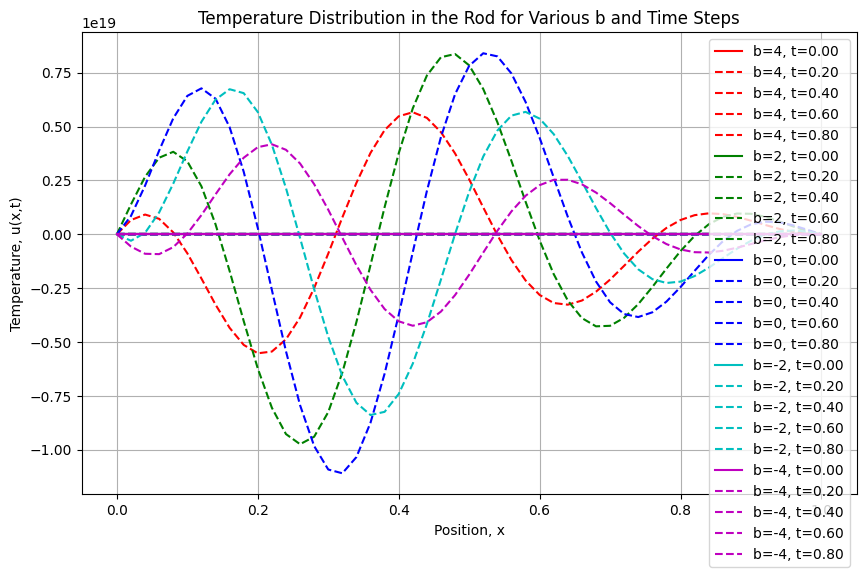

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

def crank_nicolson(b, N=50, L=1.0, T=1.0, dx=0.02, dt=0.005, timesteps=200):
    # Define the spatial and time grids
    x = np.linspace(0, L, N+1)   # N+1 points including the boundaries
    u = np.ones(N+1)            # Initial condition: u(x,0) = 0
    u_new = np.zeros(N+1)        # To store the new values of u at each timestep

    # Define coefficients for the Crank-Nicolson method
    alpha = dt / dx**2
    beta = b * dt / (2 * dx)

    # Setup the matrix for the Crank-Nicolson method
    A = np.zeros((3, N-1))
    for i in range(1, N):
        A[0, i-1] = -alpha / 2 + beta / 2
        A[1, i-1] = 1 + alpha
        A[2, i-1] = -alpha / 2 - beta / 2

    # Store solutions for various times
    solutions = []

    # Time integration loop
    for n in range(timesteps):
        # Right-hand side: B * u
        rhs = np.zeros(N-1)
        for i in range(1, N):
            rhs[i-1] = (u[i-1] * (1 - alpha) + u[i] * (1 + alpha)) / 2

        # Solve the linear system A * u_new = rhs
        u_new[1:N] = solve_banded((1, 1), A, rhs)

        # Apply boundary conditions (u(0,t) = u(1,t) = 0)
        u_new[0] = u_new[N] = 0

        # Update solution
        u = u_new.copy()

        # Save solution at select times for plotting
        if n % (timesteps // 5) == 0:  # Save solution every few timesteps
            solutions.append(u.copy())

    return x, solutions

# Parameters
N = 50            # Number of spatial divisions
L = 1.0           # Length of the rod
T = 1.0           # Total time to simulate
dx = L / N        # Spatial step
dt = 0.01         # Time step
timesteps = int(T / dt)

# Solve for different values of b
b_values = [4, 2, 0, -2, -4]
colors = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(10, 6))

for i, b in enumerate(b_values):
    # Solve using Crank-Nicolson method
    x, solutions = crank_nicolson(b, N=N, L=L, T=T, dx=dx, dt=dt, timesteps=timesteps)

    # Plot the solution for different time points
    for j, sol in enumerate(solutions):
        plt.plot(x, sol, label=f'b={b}, t={j*(T/5):.2f}', color=colors[i], linestyle='--' if j > 0 else '-')

plt.xlabel('Position, x')
plt.ylabel('Temperature, u(x,t)')
plt.title('Temperature Distribution in the Rod for Various b and Time Steps')
plt.legend()
plt.grid(True)
plt.show()



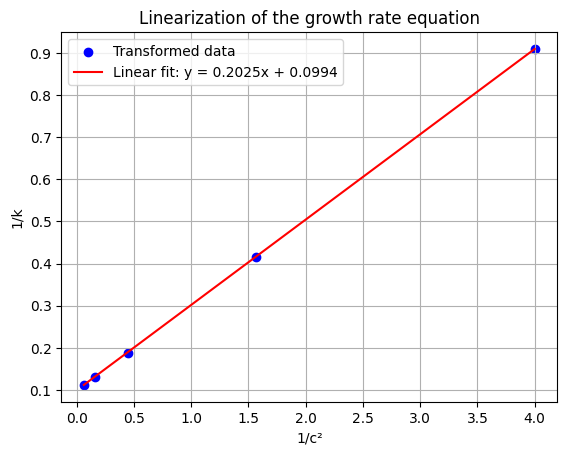

Estimated k_max: 10.0607
Estimated c_s: 2.0372
Predicted growth rate at c = 2 mg/L: 6.6658 per d


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Given data
c = np.array([0.5, 0.8, 1.5, 2.5, 4.0])
k = np.array([1.1, 2.4, 5.3, 7.6, 8.9])

# Transform the data
x = 1 / c**2
y = 1 / k

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate k_max and c_s from slope and intercept
k_max = 1 / intercept
c_s = slope * k_max

# Predict the growth rate at c = 2 mg/L
c_predict = 2
k_predict = k_max * c_predict**2 / (c_s + c_predict**2)

# Plotting the linear regression
plt.scatter(x, y, label='Transformed data', color='blue')
plt.plot(x, slope * x + intercept, label=f'Linear fit: y = {slope:.4f}x + {intercept:.4f}', color='red')
plt.xlabel('1/c²')
plt.ylabel('1/k')
plt.title('Linearization of the growth rate equation')
plt.legend()
plt.grid()
plt.show()

# Output results
print(f"Estimated k_max: {k_max:.4f}")
print(f"Estimated c_s: {c_s:.4f}")
print(f"Predicted growth rate at c = 2 mg/L: {k_predict:.4f} per d")
